In [1]:
%load_ext autoreload
%autoreload
%matplotlib inline

import pandas as pd
import numpy as np
import _pickle as pickle
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook
import json

import nltk
from nltk import Text
from nltk.corpus import stopwords as STOPWORDS
from nltk.corpus import words as WORDS
from nltk.tag import untag
import math
import os
import re

from sklearn import preprocessing

import gensim
from gensim.models import Word2Vec, Doc2Vec, FastText
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
from gensim.models.doc2vec import TaggedDocument

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager
plt.rc('font', family='AppleGothic')
# plt.text(0.3, 0.3, '한글', size=100)
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
d2v = Doc2Vec.load('doc2vec.model')

In [12]:
d2v.docvecs.most_similar(positive=['nike'], topn=500)

[('acronym', 0.7368118762969971),
 ('underarmour', 0.7342796921730042),
 ('gyakusou', 0.7143141627311707),
 ('yeezy', 0.7069796323776245),
 ('acoldwall', 0.6853988766670227),
 ('offwhite', 0.6551316976547241),
 ('undefeated', 0.6459038257598877),
 ('descente', 0.6299546957015991),
 ('undercover', 0.6257532835006714),
 ('ovo', 0.6123138666152954),
 ('kith', 0.5992926359176636),
 ('johnelliott', 0.5972574353218079),
 ('wilson', 0.5927096009254456),
 ('asics', 0.59227454662323),
 ('onitsukatiger', 0.5887162685394287),
 ('cavempt', 0.5819348096847534),
 ('fog', 0.5768957138061523),
 ('midnightstudios', 0.5759108066558838),
 ('rickowens', 0.5755981206893921),
 ('henderscheme', 0.5749586224555969),
 ('visvim', 0.5690446496009827),
 ('umbro', 0.5664684176445007),
 ('supreme', 0.5659117698669434),
 ('bbc', 0.5612753629684448),
 ('neighborhood', 0.5564499497413635),
 ('spyder', 0.5517867803573608),
 ('y3', 0.5494868755340576),
 ('1017alyx9sm', 0.5481456518173218),
 ('huf', 0.5457662343978882),


In [3]:
d2v.docvecs.most_similar(positive=['nike', 'supreme'], negative=['adidas'])

[('acronym', 0.543955385684967),
 ('stussy', 0.5435560941696167),
 ('huf', 0.5298465490341187),
 ('gyakusou', 0.5288013815879822),
 ('commedesgarcons', 0.5286949276924133),
 ('bape', 0.5238116383552551),
 ('visvim', 0.5196268558502197),
 ('acoldwall', 0.5009793043136597),
 ('wilson', 0.4843617081642151),
 ('incase', 0.4782276451587677)]

In [174]:
d2v.wv.most_similar(positive=['걸스아웃'], topn=30)

KeyError: "word '걸스아웃' not in vocabulary"

In [175]:
indexity = {
    '실용': '실용 유용한 활용 useful practical 여러가지',
    '중저가': '저가 저렴 중저가 가성비 cheap 싸다',
    '고가': '고가 럭셔리 고급 호화 명품 비싼 expensive luxury lux pricy pricey',
    '과시': '과시 간지 자랑 허세 최애 개시 언박싱 드디어 bluff',
    '인지도': '인지도 유명 대중성 대중 널리 국민 아는 네임드 popular massive mass',
    '유행': '유행 대세 트렌디 트랜디 트렌드 트랜드 trend trendy 변화 새로운 민감 예민 신상 최신',
    '독창성': '독창성 유니크 독특 독창 unique 개성 only 참신 신선 특이 아이디어',
    '진귀': '진귀 레어 응모 래플 드로우 리셀 희귀 raffle rare rareness',
    '사회공헌': '사회공헌 개념 철학 사회활동 의식 환경 착한 공정 기여',
    '시선': '시선 눈치 무난 안심 보장 믿는 믿고 믿음',
    '선도력': '선도력 앞서가는 과감 선도 선구 대담 깡패 리더 leader 리더십 리더쉽 leadership',
    '페르소나': '페르소나 성격 캐릭터 character 이미지 대리만족 아이덴티티 믿음 예측 견고 일관 지속',
    '제품기대수명': '기대수명 품질 퀄리티 안정 quality 슬로우 오래 평생 십년',
    '할인': '할인 세일 마크다운 sale markdown 특가 시즌오프 쿠폰 기획전',
    '러닝': '러닝 달리기 운동 run running 마라톤 marathon 뛰다 뛰기 조깅 jogging',
    '트레이닝': '트레이닝 필라테스 헬스 health 요가 운동 훈련 yoga train training 트랙 스웻팬츠 track sweatpants',
    '아웃도어': '아웃도어 야외 등산 캠핑 텐트 tent camp camping outdoor 방수 고어텍스 날씨',
    '축구': '축구 풋볼 사커 월드컵 박지성 메시 호날두 첼시 레알마드리드 맨유 토트넘 손흥민 football soccer',
    '야구': '야구 baseball 베이스볼 메이저리그 프로야구 류현진 선발 완봉',
    '농구': '농구 basketball 바스켓볼 조던 조단 마이클조던 jordan',
    '테니스': '테니스 tennis 정현 윔블던 레슨 시합 라켓',
    '골프': '골프 golf 타이거우즈 우즈 pga 스윙 골프연습장 프로 레슨 라운딩 우드 드라이버 골프공 골프화 아이언 테일러메이드 타이틀리스트 titlist',
    '스케이트보드': '스케이트보드 skateboard 보드 board 팔라스 슈프림 palace supreme 쓰레셔 트래셔',
    '힙합': '힙합 hiphop 랩 rap 비트 beat 칸예 드레이크 쇼미더머니 타투 문신 tatoo',
    '그래피티': '그래피티 graffiti 힙합 스트리트 street 저항',
    '미술관': '미술관 예술 미술 아트 문화 갤러리 art gallery 뮤지엄 museum 전시회',
    '티셔츠': '티셔츠 반팔티 긴팔티 셔츠 shirt 숏슬리브 롱슬리브 슬리브 sleeve',
    '맨투맨': '맨투맨 스웻셔츠 sweatshirt 상의',
    '스니커즈': '스니커즈 sneakers 운동화 신발 shoe 러닝화 런닝화 코트화 실루엣 밑창 중창 미드솔 아웃솔 어퍼 갑피 신발끈 앞코 인솔',
    '팬츠': '팬츠 바지 면바지 청바지 데님 denim pants',
    '레깅스': '레깅스 leggings 타이즈 타이트',
    '후드': '후드 hood 후드집업 후드티 후디 hoody',
    '아노락': '아노락 anorak',
    '바람막이': '바람막이 윈드브레이커 windbreak',
    '아우터': '아우터 외투 outer 패딩 padding 푸퍼 롱패딩 다운 점퍼 자켓 자킷 재킷 jacket',
    '모자': '모자 야구모자 볼캡 캡 뉴에라 cap 스냅백 snapback',
    '가방': '가방 백 배낭 bag 백팩 backpack',
    '봄여름': '봄 spring ss 여름 더운 더위 폭염 열대야 써머 썸머 summer hot',
    '가을겨울': '가을 시원한 선선한 fall autumn 겨울 추운 윈터 winter',
    '휴가': '휴가 여름휴가 물놀이 바캉스 vacation 연휴 방학',
    '여행': '여행 trip journey 트래킹 tracking 기차여행',
    '신학기': '신학기 새학기 개학 입학',
    '소풍': '소풍 피크닉 picnic 수학여행 엠티 나들이',
}

In [176]:
bid = {}
for _id, desc in indexity.items():
    val_tup = d2v.docvecs.most_similar([d2v.infer_vector(desc.split(' '), epochs=500)], topn=400)
    
    for bname, val in val_tup:
        if bname in ['ootd','fashion','category']:
            continue
            
        if bname in bid:
            bid[bname][_id] = val
        else:
            bid[bname] = {_id:val}
            
bid = pd.DataFrame(bid).T

In [177]:
bid

,실용,중저가,고가,과시,인지도,유행,독창성,진귀,사회공헌,시선,...,바람막이,아우터,모자,가방,봄여름,가을겨울,휴가,여행,신학기,소풍
time,0.868612,0.667284,0.440802,0.635401,0.618833,0.620868,0.589628,0.515299,0.644506,0.701676,...,0.752198,0.764572,0.817517,0.750965,0.802186,0.780282,0.822090,0.556722,0.658138,0.724300
tomboy,0.837676,0.692864,0.526817,0.644551,0.642641,0.641927,0.598903,0.556749,0.655487,0.725839,...,0.770157,0.809427,0.821577,0.753613,0.821279,0.751282,0.801516,0.577075,0.697703,0.699772
aimeleondore,0.830200,0.719585,0.448585,0.684159,0.638413,0.593533,0.500253,0.691958,0.726109,0.742812,...,0.830134,0.801713,0.858674,0.829132,0.809582,0.778839,0.781030,0.627468,0.756512,0.713606
helmutlang,0.826965,0.735624,0.494003,0.716480,0.635988,0.596142,0.501550,0.653525,0.690329,0.721507,...,0.810461,0.831865,0.846877,0.811156,0.838619,0.758208,0.835237,0.626183,0.722969,0.760035
martinerose,0.826835,0.734833,0.510195,0.683928,0.662083,0.602094,0.494793,0.693326,0.729765,0.747994,...,0.822037,0.862318,0.882445,0.856544,0.859860,0.813416,0.871137,0.683648,0.777712,0.786185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
puma,0.363457,0.434448,0.161183,0.322092,0.333534,0.219319,0.194339,0.501371,0.469073,0.395926,...,0.373255,0.480805,0.474992,0.538112,0.465338,0.531851,0.443693,0.325786,0.588207,0.415396
mcm,0.355862,0.222381,0.276221,0.321750,0.415600,0.258823,0.183356,0.418271,0.427496,0.362646,...,0.286794,0.536663,0.593733,0.624592,0.450158,0.457376,0.391341,0.193041,0.269301,0.409196
adidas,0.355072,0.352163,0.262685,0.369409,0.316097,0.142140,0.082643,0.624267,0.504387,0.429772,...,0.446186,0.399817,0.425512,0.393925,0.396061,0.456997,0.367748,0.415820,0.466315,0.235715
beyondcloset,0.315149,0.271388,0.146533,0.367895,0.199074,0.310844,0.162369,0.286117,0.393276,0.260197,...,0.464876,0.456959,0.538127,0.486720,0.447220,0.345360,0.403153,0.249423,0.432894,0.529123


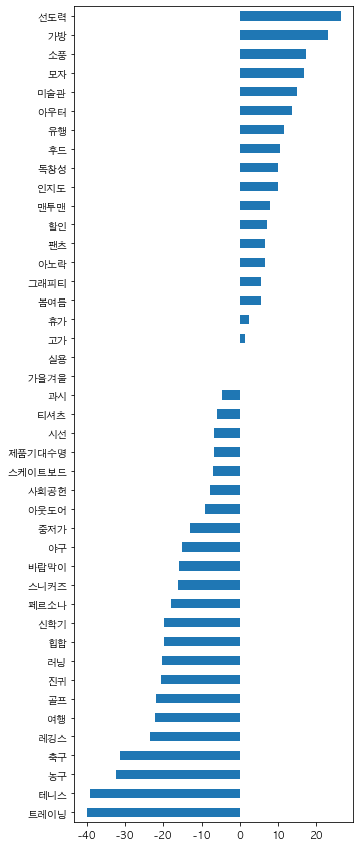

In [191]:
((bid.loc['mcm'] - bid.loc['adidas']).sort_values()*100).plot.barh(figsize=(5,15));

In [179]:
((bid.loc['adidas'] - bid.loc['nike']).sort_values()*100)

페르소나     -16.218066
테니스      -15.900117
선도력      -13.167062
그래피티     -12.925124
여행       -12.185538
러닝       -11.869341
농구       -11.542052
시선       -11.319005
과시       -11.037990
유행       -10.381316
골프        -9.880257
봄여름       -8.317053
중저가       -8.067545
트레이닝      -6.135350
인지도       -4.126430
소풍        -3.742123
고가        -3.155836
팬츠        -2.029058
후드        -2.018839
실용        -1.641038
독창성       -1.511372
힙합        -1.462382
휴가        -1.306564
축구        -0.909138
진귀        -0.770438
바람막이      -0.762650
아웃도어      -0.178120
야구         0.233638
아우터        0.241154
가을겨울       0.624344
레깅스        1.104572
할인         1.767451
맨투맨        1.877141
가방         3.314030
티셔츠        3.656363
아노락        3.681970
모자         3.698453
미술관        4.730222
스니커즈       4.958579
스케이트보드     5.161428
신학기        6.584698
제품기대수명     7.992367
사회공헌      18.296197
dtype: float64

In [188]:
100*bid.loc[['crocs', 'nike']].T

,crocs,nike
실용,55.585039,37.148273
중저가,67.197949,43.283835
고가,34.177202,29.424295
과시,53.871185,47.978911
인지도,43.393683,35.736147
유행,40.816969,24.595338
독창성,33.957034,9.775624
진귀,48.672119,63.197100
사회공헌,59.799588,32.142505
시선,50.140774,54.296207
